# Table of Contents

### [Task 1. Scraping Top Universities](#1)
- [1.1. Scraping the 200 top elements from Top Universities](#11)

- [1.2. Sorting by ratio between faculty members and students](#12)

- [1.3. Sorting by ratio of international students](#13)

- [1.4. Sorting while grouped by country](#14)

- [1.5. Sorting while grouped by region](#15)

### [Task 2. Scraping Times Higher Education](#2)
- [2.1. Scraping the 200 top elements from Times Higher Education](#21)

- [2.2. Sorting by ratio between faculty members and students](#22)

- [2.3. Sorting by ratio of international students](#23)

- [2.4. Sorting while grouped by country](#24)

- [2.5. Sorting while grouped by region](#25)

### [Task 3. Merging Both Dataframes](#3)

### [Task 4. Exploratory Data Analysis](#4)
- [4.1. Switzerland's International Outlook](#41)

- [4.2. Does an international outlook mean both ratios of International Faculty and International Students are high?](#42)

- [4.3. What other countries benefit from their international outlook?](#43)

- [4.4. Which countries benefit from gender balance?](#44)

### [Task 5. Finding the best university with both rankings](#5)

## Task 1. Scraping Top Universities <a class="anchor" id="1"></a>

### Assignment Instructions
Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

### 1.1. Scraping the 200 top elements from Top Universities <a class="anchor" id="11"></a>

We import some libraries.

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from matplotlib import pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We establish constants we need for scraping. We found the *json* URL by using Postman on the URL given in the instructions.

In [2]:
TOP_UNIVERSITIES_URL = 'https://www.topuniversities.com'
TOP_UNIVERSITIES_JSON_URL = TOP_UNIVERSITIES_URL + '/sites/default/files/qs-rankings-data/357051.txt'
TOP_UNIVERSITIES_JSON_COLUMNS = ['title', 'rank_display', 'country', 'region']
TOP_UNIVERSITIES_HTML_COLUMNS = ['total faculty', 'inter faculty', 'total student', 'total inter']
TOP_UNIVERSITIES_NEW_COLUMNS = ['Name', 'Rank', 'Country', 'Region', 'Faculty', 'International Faculty', 'Students', 'International Students']

We will use the following helper functions for scraping:
- `get_json` fetches the *json* data for a given URL;
- `get_html_beautiful_soup` gets the `BeautifulSoup` associated with a URL;
- `get_number` gets the `int` associated with a given class name in a given `BeautifulSoup` instance.

In [3]:
def get_json(url):
    """
    Returns the json associated with given url, or an empty dict if an error arises.
    :param url: string, url target
    :return: dict
    """
    try:
        return requests.get(url).json()
    except:
        return {}

def get_html_beautiful_soup(row, url_prefix):
    """
    Returns BeautifulSoup of the target URL, or None if an error arises.
    :param row: Pandas Series, corresponding to a row of a DataFrame.
    :param url_prefix: string, corresponding to URL prefix
    :return: BeautifulSoup, or None
    """
    try:
        return BeautifulSoup(requests.get(url_prefix + row['url']).text, 'html.parser')
    except:
        return None

def get_number(soup, class_name):
    """
    Returns number associated with the given class name in the soup passed as argument, or NaN if an error arises.
    :param soup: BeautifulSoup, extracted beforehand
    :param class_name: string, targeted class name
    :return: int, or NaN
    """
    try:
        number_text = soup.find('div', class_= class_name).find('div', class_='number').text
        return int(''.join([char for char in number_text if char.isdigit()]))
    except:
        return np.NaN

We use the following function to scrape universities.

In [4]:
def scrape_universities(json_url, current_columns, new_columns, extra_columns=[], extra_url='', max_universities=200):
    """
    Returns a DataFrame instance containing all university data.
    :param json_url: string, url containing json file
    :param current_columns: list of strings, containing columns to keep
    :param new_columns: list of strings, same length as current_columns, to rename the DataFrame's columns
    :param extra_columns: list of strings, extra columns to get from specific university pages
    :param extra_url: string, url prefix to get to specific university pages
    :param max_universities: int, number of top universities to get, default is 200
    :return: DataFrame
    """
    university_df = json_normalize(get_json(json_url)['data'][:max_universities])
    if extra_columns:
        beautiful_soups = university_df.apply(lambda row: get_html_beautiful_soup(row, extra_url), axis=1)
        for column in extra_columns:
            university_df[column] = beautiful_soups.apply(lambda soup: get_number(soup, column))
    university_df = university_df[current_columns].rename(index=str, columns=dict(zip(current_columns, new_columns)))
    university_df['Rank'] = university_df['Rank'].apply(lambda x: int(x.replace('=','')))
    return university_df

We scrape the top 200 universities.

In [5]:
top_universities_df = scrape_universities(TOP_UNIVERSITIES_JSON_URL,
                                          TOP_UNIVERSITIES_JSON_COLUMNS + TOP_UNIVERSITIES_HTML_COLUMNS,
                                          TOP_UNIVERSITIES_NEW_COLUMNS, 
                                          extra_columns=TOP_UNIVERSITIES_HTML_COLUMNS,
                                          extra_url=TOP_UNIVERSITIES_URL)
top_universities_df.head()

,Name,Rank,Country,Region,Faculty,International Faculty,Students,International Students
0,Massachusetts Institute of Technology (MIT),1,United States,North America,2982.0,1679.0,11067.0,3717.0
1,Stanford University,2,United States,North America,4285.0,2042.0,15878.0,3611.0
2,Harvard University,3,United States,North America,4350.0,1311.0,22429.0,5266.0
3,California Institute of Technology (Caltech),4,United States,North America,953.0,350.0,2255.0,647.0
4,University of Cambridge,5,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0


### 1.2. Sorting by ratio between faculty members and students <a class="anchor" id="12"></a>

We establish a sorting helper function, called `insert_column_and_sort`, to insert and compute a new column and then sort the values by this new column.

In [6]:
def insert_column_and_sort(dataframe, columns, head_elements=5):
    """
    Computes new column based on the division of one column by another one and returns it.
    :param dataframe: DataFrame, targeted instance
    :param columns: list of 3 strings and 2 booleans, containing names of the new column, 
                    numerator column and denominator column, and 2 booleans determining
                    if denominator column includes numerator one, and order of sorting
    :param head_elements: int, number of head elements to be shown
    :return: DataFrame
    """
    df_copy = dataframe.copy()
    new_column, numerator, denominator, denominator_includes_numerator, ascending = columns
    numerator_df = dataframe[numerator]
    denominator_df = dataframe[denominator]
    if denominator_includes_numerator:
        denominator_df = denominator_df - numerator_df
    df_copy[new_column] = numerator_df / denominator_df
    return df_copy.sort_values(new_column, ascending=ascending).head(head_elements)

We introduce a new column for the ratio between faculty members and students, such that each value is the average number of students per faculty member. Then, we sort the top universities scraped by this ratio in ascending order.

In [7]:
STUDENT_STAFF_RATIO = ['Student-Staff Ratio', 'Students', 'Faculty', False, True]
insert_column_and_sort(top_universities_df, STUDENT_STAFF_RATIO)

,Name,Rank,Country,Region,Faculty,International Faculty,Students,International Students,Student-Staff Ratio
3,California Institute of Technology (Caltech),4,United States,North America,953.0,350.0,2255.0,647.0,2.366212
15,Yale University,16,United States,North America,4940.0,1708.0,12402.0,2469.0,2.510526
5,University of Oxford,6,United Kingdom,Europe,6750.0,2964.0,19720.0,7353.0,2.921481
4,University of Cambridge,5,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0,3.418944
16,Johns Hopkins University,17,United States,North America,4462.0,1061.0,16146.0,4105.0,3.618557


### 1.3. Sorting by ratio of international students <a class="anchor" id="13"></a>

Likewise, we introduce a new column for the ratio of international students, such that each value is the average number of international students per non-international student. Then, we sort the top universities scraped by this ratio in **descending** order.

In [8]:
INTL_STUDENT_RATIO = ['International Student Ratio', 'International Students', 'Students', True, False]
insert_column_and_sort(top_universities_df, INTL_STUDENT_RATIO)

,Name,Rank,Country,Region,Faculty,International Faculty,Students,International Students,International Student Ratio
34,London School of Economics and Political Scien...,35,United Kingdom,Europe,1088.0,687.0,9760.0,6748.0,2.240372
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,Switzerland,Europe,1695.0,1300.0,10343.0,5896.0,1.325838
7,Imperial College London,8,United Kingdom,Europe,3930.0,2071.0,16090.0,8746.0,1.190904
198,Maastricht University,200,Netherlands,Europe,1277.0,502.0,16385.0,8234.0,1.010183
47,Carnegie Mellon University,47,United States,North America,1342.0,425.0,13356.0,6385.0,0.915937


### 1.4. Sorting while grouped by country <a class="anchor" id="14"></a>

We make a short helper function, called `group_insert_sort`, to group by a column, insert another one and sort by its values. It then shows the results in a bar chart.

In [9]:
def group_insert_sort(dataframe, group_by, columns):
    """
    Computes new column based on the division of one column by another one and returns it.
    Then, plots t
    :param dataframe: DataFrame, targeted instance
    :param group_by: string, name of the column by which dataframe is grouped
    :param columns: list of 3 strings and 2 booleans, containing names of the new column, 
                    numerator column and denominator column, and 2 booleans determining
                    if denominator column includes numerator one, and order of sorting
    :return: bar chart
    """
    return insert_column_and_sort(dataframe.groupby(group_by).mean(), columns, head_elements=None)[[columns[0]]].plot.bar()

The top universities by country and by student-staff ratio are the following. We observe that Russia has distinctly the lowest number of students per staff, as it is the only country dipping below 5.

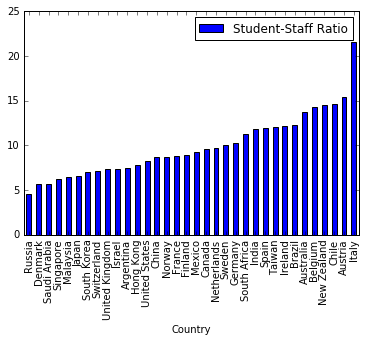

In [10]:
group_insert_sort(top_universities_df, 'Country', STUDENT_STAFF_RATIO)

The top universities by country and by international student ratio are the following. We observe that Australia and the UK stand out as having the highest international outlook, followed closely by Hong Kong, Austria and Switzerland.

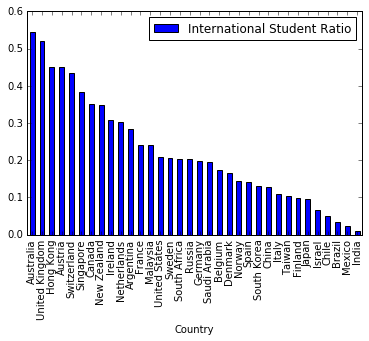

In [11]:
group_insert_sort(top_universities_df, 'Country', INTL_STUDENT_RATIO)

### 1.5. Sorting while grouped by region <a class="anchor" id="15"></a>

The top universities by region and by student-staff ratio are the following. We observe that Asia is the only continent which student-staff ratio is below 8.

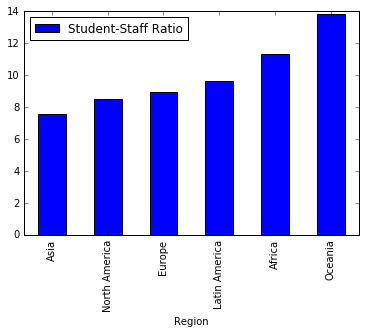

In [12]:
group_insert_sort(top_universities_df, 'Region', STUDENT_STAFF_RATIO)

The top universities by region and by international student ratio are the following. We observe that Oceania has on average more than 50% of international students in its student body, exceeding by more than 20% the other continents.

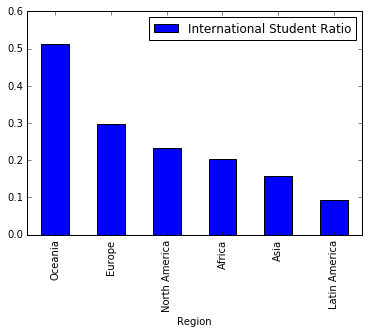

In [13]:
group_insert_sort(top_universities_df, 'Region', INTL_STUDENT_RATIO)

## Task 2. Scraping Times Higher Education <a class="anchor" id="2"></a>

### Assignment Instructions

Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

### 2.1. Scraping the top 200 elements from Times Higher Education <a class="anchor" id="21"></a>

We establish the following constants.

In [14]:
TIMES_HIGHER_ED_JSON_URL = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
TIMES_HIGHER_ED_JSON_COLUMNS = ['name', 'rank', 'location', 'stats_number_students', 'stats_student_staff_ratio', 'stats_pc_intl_students', 'stats_female_male_ratio']
TIMES_HIGHER_ED_NEW_JSON_COLUMNS = ['Name', 'Rank', 'Country', 'Students', 'Student-Staff Ratio', 'Percentage of International Students', 'Female-Male Ratio']

Then we scrape the universities from Times Higher Education.

In [15]:
times_higher_ed_df = scrape_universities(TIMES_HIGHER_ED_JSON_URL, 
                                         TIMES_HIGHER_ED_JSON_COLUMNS, 
                                         TIMES_HIGHER_ED_NEW_JSON_COLUMNS)
times_higher_ed_df.head()

,Name,Rank,Country,Students,Student-Staff Ratio,Percentage of International Students,Female-Male Ratio
0,University of Oxford,1,United Kingdom,"20,409",11.2,38%,46 : 54
1,University of Cambridge,2,United Kingdom,"18,389",10.9,35%,45 : 55
2,California Institute of Technology,3,United States,"2,209",6.5,27%,31 : 69
3,Stanford University,3,United States,"15,845",7.5,22%,42 : 58
4,Massachusetts Institute of Technology,5,United States,"11,177",8.7,34%,37 : 63


We see that the Female-Male Ratio has values of type `string` or `None`. We will make them of type `float`.

In [16]:
def correct_gender_ratio(ratio):
    """
    Transforms the Female-Male Ratio into a float instance comprised between 0 and 1.
    :param ratio: Series element (string or null)
    :return: int or None
    """
    if pd.notnull(ratio):
        return int(ratio.split(' :')[0])/100
    else:
        return ratio
        
times_higher_ed_df['Female-Male Ratio'] = times_higher_ed_df['Female-Male Ratio'].apply(correct_gender_ratio)

### 2.2. Sorting by ratio between faculty members and students <a class="anchor" id="22"></a>

There is already a *Student-Staff Ratio* column. We just need to make the values of that column `float` elements and then sort the table by it.

In [17]:
STUDENT_STAFF = "Student-Staff Ratio"
times_higher_ed_df[STUDENT_STAFF] = times_higher_ed_df[STUDENT_STAFF].apply(float)
times_higher_ed_df.sort_values(STUDENT_STAFF).head()

,Name,Rank,Country,Students,Student-Staff Ratio,Percentage of International Students,Female-Male Ratio
105,Vanderbilt University,105,United States,"12,011",3.3,13%,0.53
109,University of Copenhagen,109,Denmark,"30,395",4.1,14%,0.58
12,Johns Hopkins University,13,United States,"15,498",4.3,24%,0.52
11,Yale University,12,United States,"12,155",4.3,21%,0.49
153,University of Rochester,153,United States,"9,636",4.3,29%,0.49


### 2.3. Sorting by ratio of international students <a class="anchor" id="23"></a>

There's already a *Percentage of International Students* column and we only need to make its values `float` instances. Ranking by the percentage of international students is equivalent to ranking by their ratio.

In [18]:
INTL_PERCENTAGE = "Percentage of International Students"
times_higher_ed_df[INTL_PERCENTAGE] = times_higher_ed_df[INTL_PERCENTAGE].apply(lambda x: float(x.strip('%'))/100)
times_higher_ed_df.sort_values(INTL_PERCENTAGE, ascending=False).head()

,Name,Rank,Country,Students,Student-Staff Ratio,Percentage of International Students,Female-Male Ratio
24,London School of Economics and Political Science,25,United Kingdom,"10,065",12.2,0.71,0.52
178,University of Luxembourg,179,Luxembourg,"4,969",14.6,0.57,0.50
37,École Polytechnique Fédérale de Lausanne,38,Switzerland,"9,928",11.2,0.55,0.28
7,Imperial College London,8,United Kingdom,"15,857",11.4,0.55,0.37
102,Maastricht University,103,Netherlands,"16,727",18.0,0.50,0.58


### 2.4. Sorting while grouped by country <a class="anchor" id="24"></a>

We can group by country and then perform the same sorting as above, as the values are now `float` instances.

The following is the sorting by ratio between faculty members and students, grouped by country. We observe that there is some consistency in ranking between both websites, as Russia and Denmark remain in the top five, but numbers are different from the *Top Universities* website.

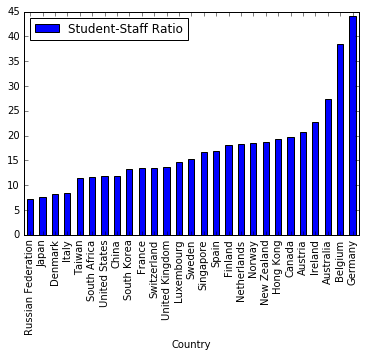

In [19]:
grouped_by_country = times_higher_ed_df.groupby('Country').mean()
grouped_by_country.sort_values(STUDENT_STAFF)[[STUDENT_STAFF]].plot.bar()

The following is the sorting by percentage of international students, grouped by country. We notice that Luxembourg is very distinctly international, but this information is new as it does not appear in the *Top Universities* ranking.

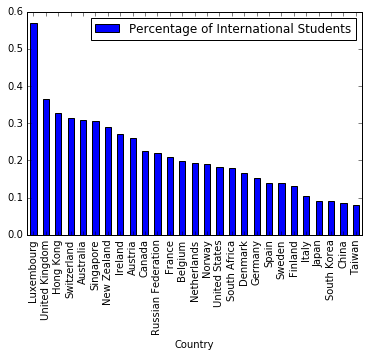

In [20]:
grouped_by_country.sort_values(INTL_PERCENTAGE, ascending=False)[[INTL_PERCENTAGE]].plot.bar()

### 2.5. Sorting while grouped by region <a class="anchor" id="25"></a>

We can group by region, however we must first associate the countries with their respective regions.

In [21]:
merged_for_region = pd.merge(times_higher_ed_df, top_universities_df[['Country', 'Region']].drop_duplicates(), on="Country")
grouped_by_region = merged_for_region.groupby('Region').mean()

The following is the sorting by ratio between faculty members and students, grouped by region. We notice this time that numbers have changed from the other ranking, as Africa comes up with the least number of students per staff.

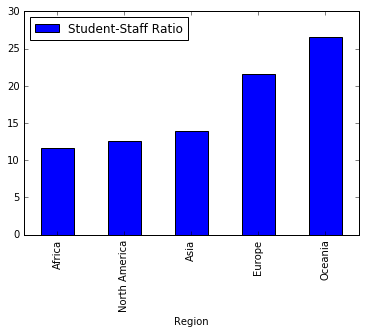

In [22]:
grouped_by_region.sort_values(STUDENT_STAFF)[[STUDENT_STAFF]].plot.bar()

The following is the sorting by percentage of international students, grouped by region. This ranking confirms Oceania's top place in international students.

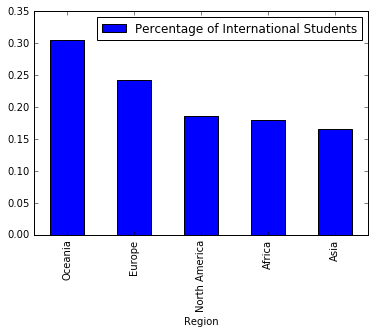

In [23]:
grouped_by_region.sort_values(INTL_PERCENTAGE, ascending=False)[[INTL_PERCENTAGE]].plot.bar()

## Task 3. Merging Both Rankings <a class="anchor" id="3"></a>

### Assignment Instructions

Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

### Answers

We merge both tables that we scraped in tasks 1 and 2.

Our method compares two sequences of words in their order, and the similarity is the number of exact matches, with words being eliminated if they are stop words and being stripped of non-alphabetical characters. No university is matched more than once.

In [24]:
import unidecode

def clean_word(word):
    """
    Cleans word of non-alphabetical characters and removes accents.
    :param word: string
    :return: string, lowercase
    """
    word = unidecode.unidecode(word)
    word = ''.join([char for char in word if char.isalpha() or char == ')'])
    return word.lower()

def is_all_caps(word):
    """
    Checks if a word is all the alphabetical characters of a word are uppercase.
    :param word: string
    :return: boolean
    """
    for char in word:
        if char.isalpha() and char.islower():
            return False
    return True

def filter_name(name):
    """
    Filters a sequence of words (a university name).
    Tokenizes, cleans tokens, and removes tokens in parentheses and stop words.
    :param name: string
    :return: 
    """
    words = [clean_word(word) for word in name.split(' ') 
             if (not is_all_caps(word) and word not in 'The of and in'.split(' ') 
                 and not (word.startswith('(') and word.endswith(')')))]
    return words

def compare_names(name1, name2):
    """
    Compares two names (of univerisities) by tokenizing, filtering tokens, cleaning tokens and 
    comparing exact words to compute similarity.
    Returns True if the two names match, False if not.
    :param name1: string
    :param name2: string
    :return: boolean
    """
    words1 = filter_name(name1)
    words2 = filter_name(name2)
    similarity_index = 0
    similarity = 0
    index1 = 0
    while index1 < len(words1) :
        for index2 in range(similarity_index, len(words2)):
            if words1[index1] == words2[index2]:
                similarity_index = index2
                similarity += 1
                break
        index1 += 1
    min_len = min(len(set(words1)), len(set(words2)))
    return similarity >= min_len

TAKEN = []

def find_closest_match(name, other_names):
    """
    Returns the closest match to given name in a series of other names, or just the name if nothing is found.
    :param name: string, given name that we want to find
    :param other_names: Pandas Series, names that the argument name will be compared to
    :return: string"""
    for other_name in other_names:
        if compare_names(name, other_name) and other_name not in TAKEN:
            TAKEN.append(other_name)
            return other_name
    return name

We replace the column `'Name'` in the Times Higher Education `DataFrame` by its closest match in the Top Universities one.

In [25]:
NAME = 'Name'
times_higher_ed_df[NAME] = times_higher_ed_df[NAME].apply(lambda name: find_closest_match(name, top_universities_df[NAME]))

Then we merge both `DataFrame` instances into one.

In [26]:
merged_df = pd.merge(top_universities_df, times_higher_ed_df.drop(labels='Country', axis=1), how='outer', on='Name', suffixes=(' (Top Unis)', ' (T.H.E.)'))
merged_df.head()

,Name,Rank (Top Unis),Country,Region,Faculty,International Faculty,Students (Top Unis),International Students,Rank (T.H.E.),Students (T.H.E.),Student-Staff Ratio,Percentage of International Students,Female-Male Ratio
0,Massachusetts Institute of Technology (MIT),1.0,United States,North America,2982.0,1679.0,11067.0,3717.0,5.0,"11,177",8.7,0.34,0.37
1,Stanford University,2.0,United States,North America,4285.0,2042.0,15878.0,3611.0,3.0,"15,845",7.5,0.22,0.42
2,Harvard University,3.0,United States,North America,4350.0,1311.0,22429.0,5266.0,6.0,"20,326",8.9,0.26,NaN
3,California Institute of Technology (Caltech),4.0,United States,North America,953.0,350.0,2255.0,647.0,3.0,"2,209",6.5,0.27,0.31
4,University of Cambridge,5.0,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0,2.0,"18,389",10.9,0.35,0.45


## Task 4. Exploratory Data Analysis <a class="anchor" id="4"></a>

### Assignment Instructions

Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

### 4.1. Switzerland's International Outlook <a class="anchor" id="41"></a>

We will look into how Switzerland's international outlook is correlated to the ranking of its universities.

We first make a `DataFrame` copy of the *merged_df* one, and add to it two columns for *International Faculty Ratio* and *International Student Ratio*.

In [27]:
correlation_df = merged_df.copy()
correlation_df['International Faculty Ratio'] = correlation_df['International Faculty']/correlation_df['Faculty']
correlation_df['International Student Ratio'] = correlation_df['International Students']/correlation_df['Students (Top Unis)']

We drop columns that are not of interest. Those are the columns containing absolute values instead of relative ones.

In [28]:
COLUMNS_OF_NO_INTEREST = ['Faculty', 'International Faculty', 'Students (Top Unis)', 'International Students', 'Students (T.H.E.)']
correlation_df = correlation_df.drop(COLUMNS_OF_NO_INTEREST, axis=1)

Let's make a heatmap to show correlations between the ranking and other variables.

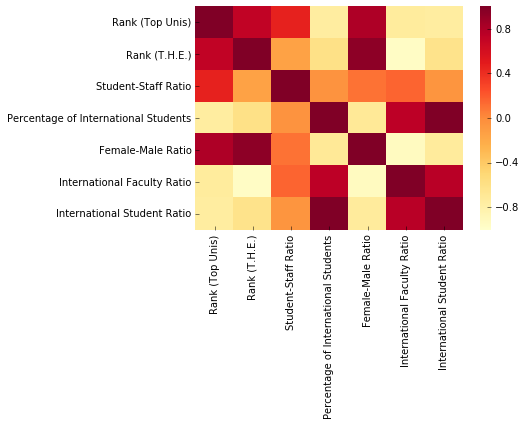

In [29]:
import seaborn as sns
corr = correlation_df[(correlation_df.Country == 'Switzerland')].corr()
sns.heatmap(corr, cmap='YlOrRd', vmin=-1, vmax=1)
plt.xticks(rotation=90)
plt.show()

In the heatmap above, the lighter a cell is, the more negative the correlation is. A variable drives the prestige of a university upwards if it is negatively correlated with the rankings.

**Conclusions:** We notice that in Switzerland, more international faculty and more international students lead to higher prestige for universities.

### 4.2. Does an international outlook mean both ratios of International Faculty and International Students are high? <a class="anchor" id="42"></a>

We take a look at the correlation between the ratios of international faculty and international students for all the universities, regardless of country.

In [30]:
corr = correlation_df.corr()
corr['International Faculty Ratio']['International Student Ratio']

0.67988593939634889

We notice that the correlation is strongly positive at around **0.68**. Therefore both ratios are tied up together.

### 4.3. What other countries benefit from their international outlook? <a class="anchor" id="43"></a>

We want to list the countries which have the most universities benefiting from an international outlook.

We first make helper functions to list them.

In [31]:
from collections import Counter

def check_condition(corr, column):
    """
    Checks whether the column is negatively correlated with either ranking.
    :param corr: DataFrame of correlations
    :param column: string
    :return: boolean
    """
    return corr['Rank (Top Unis)'][column] < -0.5 or corr['Rank (T.H.E.)'][column] < -0.5

def list_countries(df, columns):
    """
    Lists countries where the attributes in columns are negatively correlated with the rankings of their universities.
    Returns a Counter with as tuple a country and the number of universities satisfying the condition.
    :param df: DataFrame
    :param columns: list of strings
    :return: Counter
    """
    countries = []
    for country in df.Country:
        corr = df[(df.Country == country)].corr()
        condition = True
        for column in columns:
            condition = condition and check_condition(corr, column)
        if condition:
            countries.append(country)
    return Counter(countries).most_common()

Here, we list the countries in which the universities benefit from an international outlook.

In [32]:
list_countries(correlation_df, ['International Faculty Ratio', 'International Student Ratio'])

[('United Kingdom', 28),
 ('Switzerland', 7),
 ('Canada', 7),
 ('Hong Kong', 5),
 ('France', 5),
 ('Italy', 4),
 ('Austria', 2),
 ('Ireland', 2),
 ('Singapore', 2)]

### 4.4. Which countries benefit from gender balance? <a class="anchor" id="44"></a>

We list the countries which have the most universities benefiting from a high female-male ratio.

In [33]:
list_countries(correlation_df, ['Female-Male Ratio'])

[('Netherlands', 10),
 ('Australia', 9),
 ('Canada', 7),
 ('Hong Kong', 5),
 ('Sweden', 5),
 ('Italy', 4),
 ('Denmark', 3),
 ('Singapore', 2),
 ('Finland', 2)]

## Task 5. Finding the best university with both rankings <a class="anchor" id="5"></a>

### Assignment Instructions

Can you find the best university taking in consideration both rankings? Explain your approach.

### Answers

First we only keep universities present in both rankings.

In [34]:
ranking_df = merged_df.dropna()[['Name','Rank (T.H.E.)', 'Rank (Top Unis)']]

Then we create a column *Rank* which takes the mean of both rankings.

In [35]:
ranking_df['Rank'] = (ranking_df['Rank (Top Unis)'] + ranking_df['Rank (T.H.E.)'])/2

Finally we list universities by their mean rank.

In [36]:
ranking_df.sort_values('Rank').head()

,Name,Rank (T.H.E.),Rank (Top Unis),Rank
1,Stanford University,3.0,2.0,2.5
0,Massachusetts Institute of Technology (MIT),5.0,1.0,3.0
3,California Institute of Technology (Caltech),3.0,4.0,3.5
4,University of Cambridge,2.0,5.0,3.5
5,University of Oxford,1.0,6.0,3.5


So here, we notice that **Stanford University** is the best university according to this approach.

Although it is not the case in the top 5 universities abovementioned, we notice that the difference between rankings can be really high for some universities. We list the universities with the highest rank discrepancies hereafter:

In [37]:
ranking_df['Rank Discrepancy'] = np.abs(ranking_df['Rank (Top Unis)'] - ranking_df['Rank (T.H.E.)'])
ranking_df.sort_values('Rank Discrepancy', ascending=False).head()

,Name,Rank (T.H.E.),Rank (Top Unis),Rank,Rank Discrepancy
61,Shanghai Jiao Tong University,188.0,62.0,125.0,126.0
77,National Taiwan University (NTU),198.0,76.0,137.0,122.0
82,The University of Auckland,192.0,82.0,137.0,110.0
163,University of Minnesota,56.0,163.0,109.5,107.0
95,Lomonosov Moscow State University,194.0,95.0,144.5,99.0
